## 1. Read in the data

In [1]:
import json

TRPATH = "../data/data_practicephase_cleardev/ConvAbuse_dataset/ConvAbuse_train.json"
DEVPATH = "../data/data_practicephase_cleardev/ConvAbuse_dataset/ConvAbuse_dev.json"


with open(TRPATH, 'rb') as file:
    tr_data = json.load(file)
with open(DEVPATH, 'rb') as file:
    dev_data = json.load(file)

len(tr_data)

2398

In [2]:
# Check for languages
lang = set()
for val in tr_data.values():
    lang.add(val['lang'])

# Check for tasks
tasks = set()
for val in tr_data.values():
    tasks.add(val['annotation task'])

lang, tasks

({'en'}, {'abusivness detection'})

## 2. Data exploring

### 2.1 Measuring topic polarity

We use the formula `some_form` to quantify the polarizing nature of topics

In [3]:
import numpy as np


soft_label_split = []
annotator_counts = []
cov19_pol = []

for val in tr_data.values():
    polarizability = 1 - np.absolute(val['soft_label']['0'] - val['soft_label']['1'])
    soft_label_split.append(polarizability)
    annotator_counts.append(val['number of annotations'])

dev_soft_label_split = []
dev_annotator_counts = []
dev_cov19_pol = []

for val in dev_data.values():
    polarizability = 1 - np.absolute(val['soft_label']['0'] - val['soft_label']['1'])
    dev_soft_label_split.append(polarizability)
    dev_annotator_counts.append(val['number of annotations'])

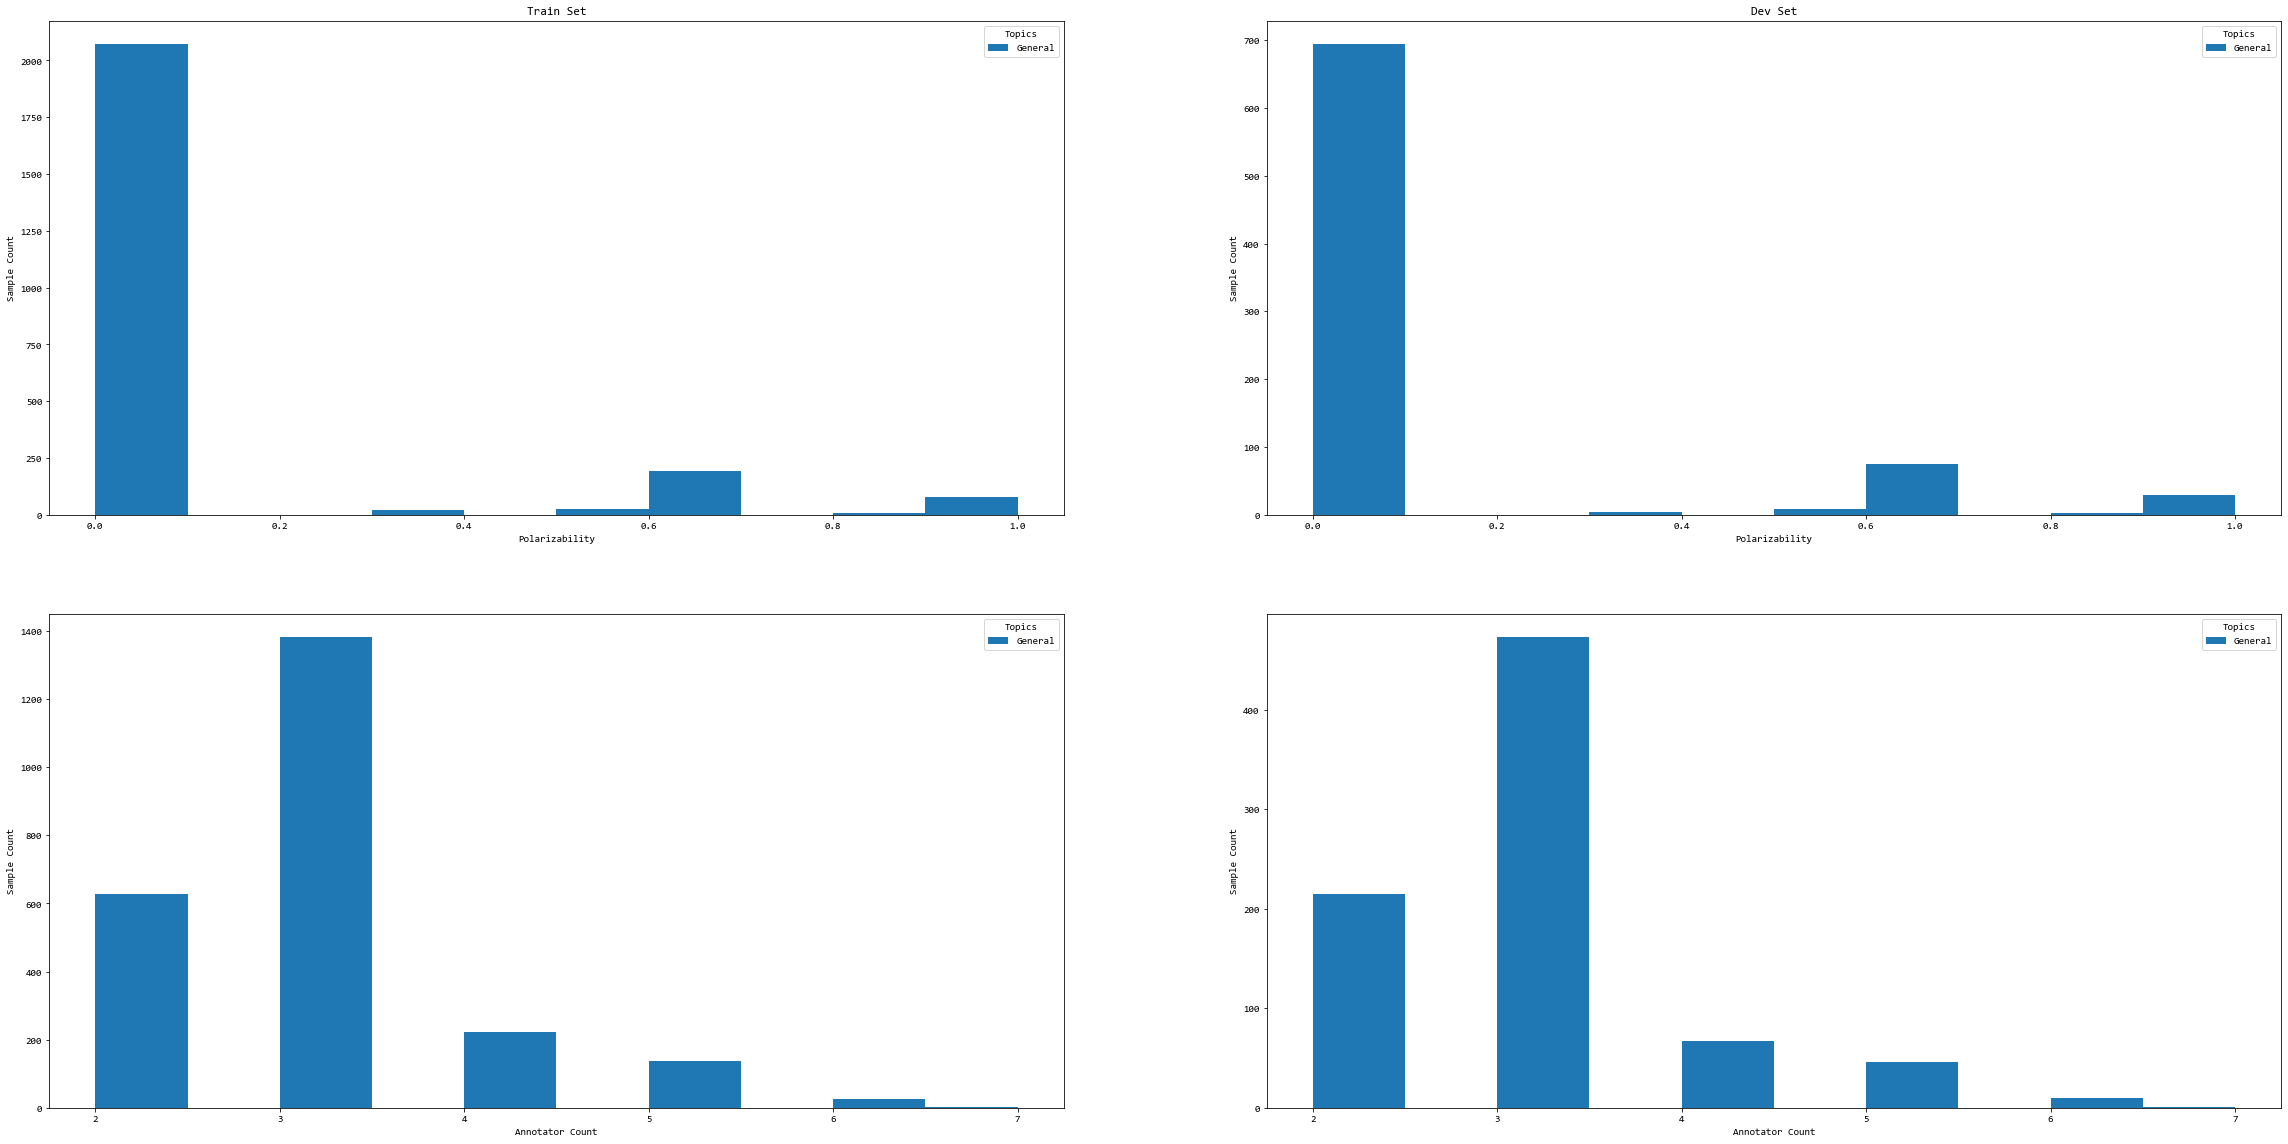

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Consolas"
plt.rcParams['font.size']=24

# Plot the histograms
fig, ax = plt.subplots(2, 2, figsize=[40, 20])
ax[0][0].hist((soft_label_split, ), label=('General'))
ax[0][0].set_xlabel('Polarizability')
ax[0][0].set_ylabel('Sample Count')
ax[0][0].legend(title="Topics")
ax[0][0].set_title('Train Set')

ax[0][1].hist((dev_soft_label_split, ), label=('General'))
ax[0][1].set_xlabel('Polarizability')
ax[0][1].set_ylabel('Sample Count')
ax[0][1].legend(title="Topics")
ax[0][1].set_title('Dev Set')

ax[1][0].hist((annotator_counts, ), label=('General'))
ax[1][0].set_xlabel('Annotator Count')
ax[1][0].set_ylabel('Sample Count')
ax[1][0].legend(title="Topics")

ax[1][1].hist((dev_annotator_counts, ), label=('General'))
ax[1][1].set_xlabel('Annotator Count')
ax[1][1].set_ylabel('Sample Count')
ax[1][1].legend(title="Topics")

plt.show()

## 3. Evaluation

In [6]:
from cnvab_modelling import AgreementModel, InteractionModel
from pytorch_lightning import Trainer, seed_everything


seed_everything(42, workers=True)

trainer = Trainer(
    deterministic=True,
    accelerator='gpu',
)

CKPT = "../models/conv-abuse/paraphrase-MiniLM-L12-v2/int-ann_dim=128-mod=8-epoch=3-val_soft_loss=0.14.ckpt"
model = AgreementModel.load_from_checkpoint(CKPT, interaction_model=InteractionModel(384, 128, modalities=8))
print("Loaded checkpoint")

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded checkpoint


In [7]:
from datautils import CnvAbBatcher, CnvAbDataModule, AnnotatorTokenizer


ann_tknzr = AnnotatorTokenizer(8)
batcher = CnvAbBatcher("sentence-transformers/paraphrase-MiniLM-L12-v2", ann_tknzr=ann_tknzr, has_targets=True)
dm = CnvAbDataModule(DEVPATH, ["abusivness detection"], batcher)
dm.setup('test')


preds = trainer.test(model=model, dataloaders=dm)

Missing logger folder: c:\repos\semeval2023-shared-task\code\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\Miniconda3\envs\expt\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:  14%|█▍        | 1/7 [00:01<00:07,  1.33s/it]

c:\ProgramData\Miniconda3\envs\expt\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Testing DataLoader 0: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


c:\ProgramData\Miniconda3\envs\expt\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 44. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        hard_score         │     0.866414487361908     │
│        soft_score         │    0.2202858030796051     │
└───────────────────────────┴───────────────────────────┘

## 4. Sample Preds

In [8]:
from datautils import CnvAbBatcher, CnvAbDataModule, AnnotatorTokenizer


PRPATH = "../data/data_evaluation/ConvAbuse_test.json"

ann_tknzr = AnnotatorTokenizer(8)

batcher = CnvAbBatcher("sentence-transformers/paraphrase-MiniLM-L12-v2", ann_tknzr=ann_tknzr, has_targets=False)
dm = CnvAbDataModule(PRPATH, ["abusivness detection"], batcher)
dm.setup('predict')


preds = trainer.predict(model=model, dataloaders=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\Miniconda3\envs\expt\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


In [9]:
import torch
hard_labels = [i[1].cpu() for i in preds]
soft_labels = [i[2].cpu() for i in preds]

In [10]:
hard_labels = torch.concat(hard_labels)
soft_labels = torch.concat(soft_labels)
results = torch.hstack((hard_labels, soft_labels))

# Round the values
results = torch.round(results, decimals=2)

In [11]:
import pandas as pd
df = pd.DataFrame(results.numpy())

df[0] = df[0].astype(int)

df.to_csv('ConvAbuse_results.tsv', sep='\t', header=False, index=False)